### 1.Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns=None
pd.options.display.max_rows=100

In [3]:
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV

In [5]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,accuracy_score,auc,roc_curve,recall_score,precision_score,f1_score

### 2.Loading the Dataset

In [6]:
df_loan=pd.read_excel('C:/Users/Sushree Jena/Desktop/imarticus/machine learning/SVM_Project/loan.xlsx',sheet_name='Data')

In [7]:
df_loan.head()

,ID,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


### 3.Exploratory Data Analysis

In [8]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP_Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [9]:
#We will convert some features into categorical which have wrongly been interpreted as numerical data

In [10]:
cols=['Education','Securities_Account','CD_Account','Online','CreditCard']

for col in cols:
    df_loan[col]=df_loan[col].astype('object')

In [11]:
#Personal Loan column is also misinterpreted as a categorical column,but we will keep it like that since it would be required in this format for model building.

In [12]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP_Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   object 
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   object 
 11  CD_Account          5000 non-null   object 
 12  Online              5000 non-null   object 
 13  CreditCard          5000 non-null   object 
dtypes: float64(1), int64(8), object(5)
memory usage: 547.0+ KB


In [13]:
df_loan.describe()

,ID,Age,Experience,Income,ZIP_Code,Family,CCAvg,Mortgage,Personal_Loan
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,56.498800,0.096000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,101.713802,0.294621
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,0.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,101.000000,0.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,635.000000,1.000000


In [14]:
df_loan['Age_cat']=pd.cut(df_loan.Age,bins=[22,30,45,68],labels=['young','middle','old'])

In [15]:
df_loan.Age_cat.value_counts()

old       2481
middle    1895
young      624
Name: Age_cat, dtype: int64

In [16]:
#Converting the Income column into a categorical column to treat outliers
df_loan['Income_cat']=pd.cut(df_loan.Income,bins=[0,70,150,225],labels=['low','medium','high'])

In [17]:
df_loan['Income_cat'].value_counts()

low       2738
medium    1820
high       442
Name: Income_cat, dtype: int64

In [18]:
#Treating the outliers in CCAvg
iqr_CCAvg=df_loan.CCAvg.quantile(.75)-df_loan.CCAvg.quantile(.25)
print(iqr_CCAvg)

LL_CCAvg=df_loan.CCAvg.quantile(.25)-(1.5*iqr_CCAvg)
print(LL_CCAvg)

UL_CCAvg=df_loan.CCAvg.quantile(.75)+(1.5*iqr_CCAvg)
print(UL_CCAvg)

1.8
-2.0
5.2


In [19]:
outliers1=df_loan.loc[df_loan.CCAvg>UL_CCAvg,['CCAvg','Income_cat']]
outliers1.Income_cat.count()

324

In [20]:
outliers1.groupby('Income_cat')['CCAvg'].median().round(2)

Income_cat
low        NaN
medium    6.32
high      6.95
Name: CCAvg, dtype: float64

In [21]:
df_loan.loc[(df_loan.CCAvg>UL_CCAvg) & (df_loan.Income_cat=='low'),'CCAvg']=0
df_loan.loc[(df_loan.CCAvg>UL_CCAvg) & (df_loan.Income_cat=='medium'),'CCAvg']=UL_CCAvg-0.67
df_loan.loc[(df_loan.CCAvg>UL_CCAvg) & (df_loan.Income_cat=='high'),'CCAvg']=UL_CCAvg

In [22]:
#Treating the outliers in Mortgage
iqr_Mortgage=df_loan.Mortgage.quantile(.75)-df_loan.Mortgage.quantile(.25)
print(iqr_Mortgage)

LL_Mortgage=df_loan.Mortgage.quantile(.25)-(1.5*iqr_Mortgage)
print(LL_Mortgage)

UL_Mortgage=df_loan.Mortgage.quantile(.75)+(1.5*iqr_Mortgage)
print(UL_Mortgage)

101.0
-151.5
252.5


In [23]:
outliers1=df_loan.loc[df_loan.Mortgage>UL_Mortgage,['Mortgage','Income_cat']]
outliers1.Income_cat.count()

291

In [24]:
outliers1.groupby('Income_cat')['Mortgage'].median()

Income_cat
low       261.5
medium    313.0
high      415.5
Name: Mortgage, dtype: float64

In [25]:
df_loan.loc[(df_loan.Mortgage>UL_Mortgage) & (df_loan.Income_cat=='low'),'Mortgage']=UL_Mortgage-154
df_loan.loc[(df_loan.Mortgage>UL_Mortgage) & (df_loan.Income_cat=='medium'),'Mortgage']=UL_Mortgage-102
df_loan.loc[(df_loan.Mortgage>UL_Mortgage) & (df_loan.Income_cat=='high'),'Mortgage']=UL_Mortgage

In [26]:
df_loan.describe()    #Checking whether outliers are treated or not

,ID,Age,Experience,Income,ZIP_Code,Family,CCAvg,Mortgage,Personal_Loan
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.812017,46.474300,0.096000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.411198,75.313338,0.294621
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,0.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,100.000000,0.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,5.200000,252.500000,1.000000


In [27]:
df_loan.describe(include='object') 

,Education,Securities_Account,CD_Account,Online,CreditCard
count,5000,5000,5000,5000,5000
unique,3,2,2,2,2
top,1,0,0,1,0
freq,2096,4478,4698,2984,3530


In [28]:
#Some values in experience column are negative. We can replace the negative numbers with 0 as no experience.

In [29]:
df_loan.loc[df_loan.Experience<0,'Experience']=0

In [30]:
#Checking for Income Distribution, CCAvg Distribution, Experience Distribution, Securities Account Countplot, Family countplot

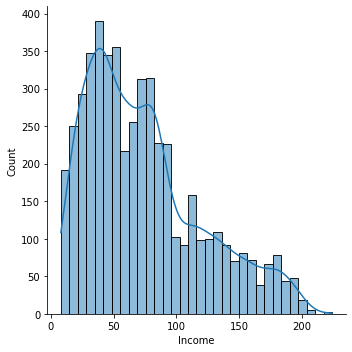

In [31]:
#Income_distribution

sns.displot(x='Income',data=df_loan,kde=True)
plt.show()

In [32]:
df_loan.Income.skew()

0.8413386072610816

The Income feature is right skewed. The skewness can be decreased if we normalise the data.

In [33]:
#Checking on Income_cat countplot

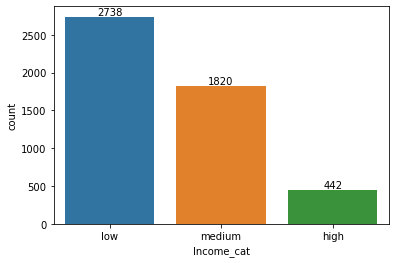

In [34]:
cp=sns.countplot(x='Income_cat',data=df_loan,)
cp.bar_label(cp.containers[0])
plt.show()

We have highest number of people belonging to low income category.Let us group it with education level now.

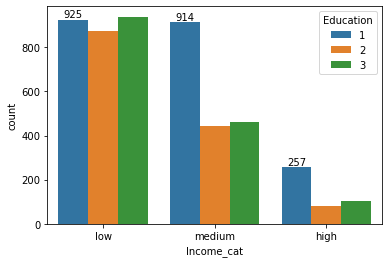

In [35]:
cp1=sns.countplot(x='Income_cat',data=df_loan,hue='Education')
cp1.bar_label(cp1.containers[0])
plt.show()

In [36]:
#CCAvg Distribution

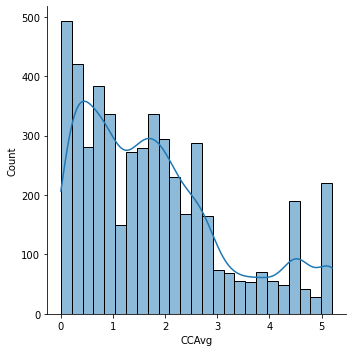

In [37]:
sns.displot(x='CCAvg',data=df_loan,kde=True)
plt.show()

The CCAvg feature is right skewed. The skewness can be decreased if we normalise the data.

In [38]:
#Experience distribution

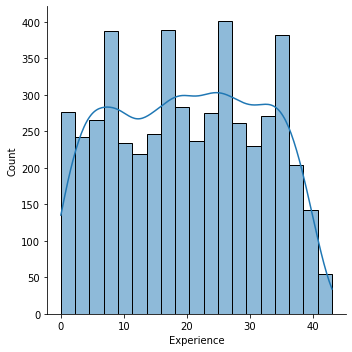

In [39]:
sns.displot(x='Experience',data=df_loan,kde=True)
plt.show()

In [40]:
df_loan.Experience.skew()

-0.017220705364694253

Data is slightly left skewed.

In [41]:
#Securities_Account countplot

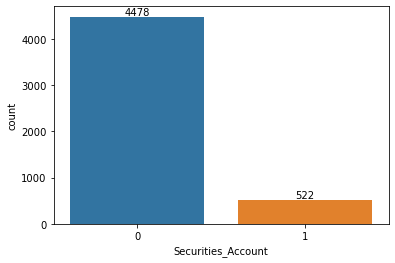

In [42]:
cp2=sns.countplot(x='Securities_Account',data=df_loan)
cp2.bar_label(cp2.containers[0])
plt.show()

There are only 522 customers having a securities account with the bank.

In [43]:
#Families countplot

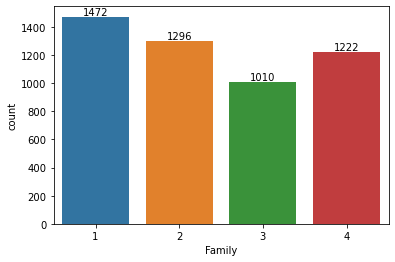

In [44]:
cp3=sns.countplot(x='Family',data=df_loan)
cp3.bar_label(cp3.containers[0])
plt.show()

There are 1470 customers with the bank who have two members in his family.

In [45]:
df_loan1=df_loan.copy(deep=True)

In [46]:
#Dropping off ID,Zip,Age and Income column since we donot require it for model building

In [47]:
df_loan1=df_loan.drop(['ID','Age','ZIP_Code','Income'],axis=1)

### 4. Dummy Encoding

In [48]:
#Dummy Encoding the Categorical variables

In [49]:
df_loan1_dummy=pd.get_dummies(df_loan1,drop_first=True)
df_loan1_dummy.head()

,Experience,Family,CCAvg,Mortgage,Personal_Loan,Education_2,Education_3,Securities_Account_1,CD_Account_1,Online_1,CreditCard_1,Age_cat_middle,Age_cat_old,Income_cat_medium,Income_cat_high
0,1,4,1.6,0.0,0,0,0,1,0,0,0,0,0,0,0
1,19,3,1.5,0.0,0,0,0,1,0,0,0,1,0,0,0
2,15,1,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0
3,9,1,2.7,0.0,0,1,0,0,0,0,0,1,0,1,0
4,8,4,1.0,0.0,0,1,0,0,0,0,1,1,0,0,0


### 5. Splitting the Data

In [50]:
#Splitting the dataset into Dependent and Independent Variable

In [51]:
X=df_loan1_dummy.drop('Personal_Loan',axis=1)

In [52]:
y=df_loan1_dummy['Personal_Loan']

In [53]:
#Splitting the dataset into Train and Test Set

In [54]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)

In [55]:
X_train.shape

(4000, 14)

In [56]:
y_train.shape

(4000,)

In [57]:
X_test.shape

(1000, 14)

In [58]:
y_test.shape

(1000,)

In [59]:
counter=Counter(y_train)
counter

Counter({0: 3620, 1: 380})

We can see that only around 10% data is in True class and 90% is in False class. So, this is an imbalanced class.We need to balance it now.

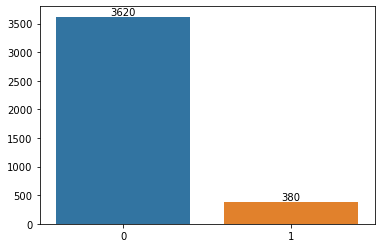

In [60]:
#Checking for distribution
plot=sns.barplot(x=list(counter.keys()),y=list(counter.values()))
plot.bar_label(plot.containers[0])
plt.show()

In [61]:
#Applying SMOTE to balance the class

In [62]:
oversample=SMOTE()

In [63]:
X_train,y_train=oversample.fit_resample(X_train,y_train)

In [64]:
X_train.shape

(7240, 14)

In [65]:
y_train.shape

(7240,)

### 6.Data Scaling

In [66]:
#Scaling the data

In [67]:
sc=StandardScaler()

In [68]:
X_train_scaled=sc.fit_transform(X_train)
X_test_scaled=sc.transform(X_test)

### 7.Model Building

#### A.Linear Kernel

In [69]:
svc1=SVC(kernel='linear')

In [70]:
svc1.fit(X_train_scaled,y_train)

SVC(kernel='linear')

In [71]:
predicted_result=svc1.predict(X_test_scaled)

In [72]:
cm1=confusion_matrix(y_test,predicted_result)
cm1

array([[754, 146],
       [ 25,  75]], dtype=int64)

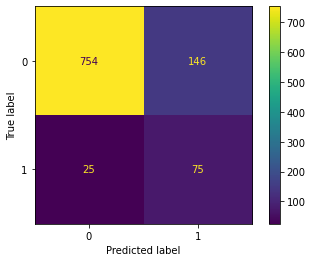

In [73]:
ConfusionMatrixDisplay(cm1).plot()
plt.show()

In [74]:
print(classification_report(y_test,predicted_result))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       900
           1       0.34      0.75      0.47       100

    accuracy                           0.83      1000
   macro avg       0.65      0.79      0.68      1000
weighted avg       0.91      0.83      0.86      1000



In [75]:
fpr,tpr,thresholds=roc_curve(y_test,predicted_result)

In [76]:
AUC=auc(fpr,tpr).round(3)

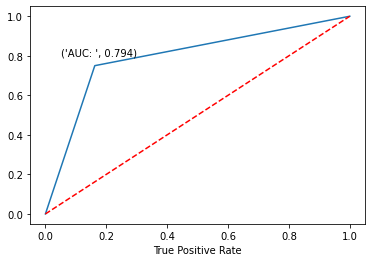

In [77]:
plt.plot(fpr,tpr)

plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')

plt.plot([0,1],[0,1],'r--')
plt.text(x=0.05,y=0.8,s=('AUC: ',AUC))

plt.show()

The model is 83 % accurate but the recall value is 77% and it has an AUC score of 0.802

In [78]:
#Tabulating the results

In [79]:
cols=['Model','Accuracy','Recall','Precision','AUC_Score','f1_score']

result=pd.DataFrame(columns=cols)

SVM_linear_metrics=pd.Series({'Model':'SVM_Linear',
                            'Accuracy':accuracy_score(y_test,predicted_result),
                             'Recall':recall_score(y_test,predicted_result),
                             'Precision':precision_score(y_test,predicted_result),
                              'AUC_Score':AUC,
                              'f1_score':f1_score(y_test,predicted_result)
                             })
result=result.append(SVM_linear_metrics,ignore_index=True)

result

,Model,Accuracy,Recall,Precision,AUC_Score,f1_score
0,SVM_Linear,0.829,0.75,0.339367,0.794,0.46729


#### B.Kernel=Radial

In [80]:
svc2=SVC(kernel='rbf')

In [81]:
svc2.fit(X_train_scaled,y_train)

SVC()

In [82]:
predicted_result=svc2.predict(X_test_scaled)

In [83]:
cm2=confusion_matrix(y_test,predicted_result)
cm2

array([[775, 125],
       [ 22,  78]], dtype=int64)

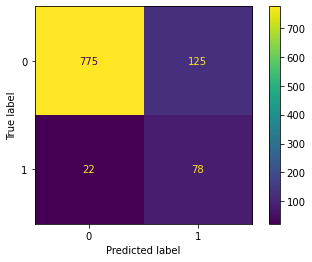

In [84]:
ConfusionMatrixDisplay(cm2).plot()
plt.show()

In [85]:
print(classification_report(y_test,predicted_result))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       900
           1       0.38      0.78      0.51       100

    accuracy                           0.85      1000
   macro avg       0.68      0.82      0.71      1000
weighted avg       0.91      0.85      0.87      1000



In [86]:
fpr,tpr,thresholds=roc_curve(y_test,predicted_result)

In [87]:
AUC=auc(fpr,tpr).round(3)

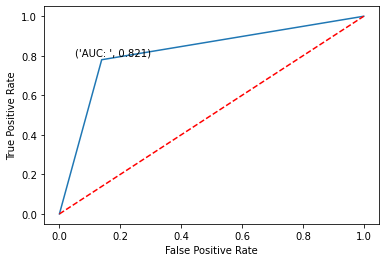

In [88]:
plt.plot(fpr,tpr)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot([0,1],[0,1],'r--')

plt.text(x=0.05,y=0.8,s=('AUC: ',AUC))

plt.show()

We can see that the accuracy of the model has increased to 84% and the recall value is 78% with precision of 87%. The ROC is also better as compared to linear kernel.

In [89]:
#Tabulating the Results

In [90]:
SVM_rbf_metrics=pd.Series({'Model':'SVM_rbf',
                            'Accuracy':accuracy_score(y_test,predicted_result),
                             'Recall':recall_score(y_test,predicted_result),
                             'Precision':precision_score(y_test,predicted_result),
                              'AUC_Score':AUC,
                              'f1_score':f1_score(y_test,predicted_result)
                             })
result=result.append(SVM_rbf_metrics,ignore_index=True)

result

,Model,Accuracy,Recall,Precision,AUC_Score,f1_score
0,SVM_Linear,0.829,0.75,0.339367,0.794,0.46729
1,SVM_rbf,0.853,0.78,0.384236,0.821,0.514851


#### C.Kernel=Sigmoid

In [91]:
svc3=SVC(kernel='sigmoid')

In [92]:
svc3.fit(X_train_scaled,y_train)

SVC(kernel='sigmoid')

In [93]:
predicted_result=svc3.predict(X_test_scaled)

In [94]:
cm3=confusion_matrix(y_test,predicted_result)
cm3

array([[646, 254],
       [ 32,  68]], dtype=int64)

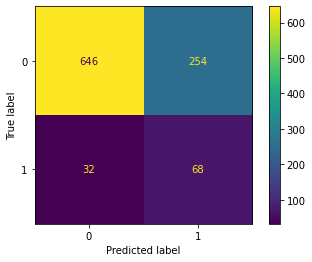

In [95]:
ConfusionMatrixDisplay(cm3).plot()
plt.show()

In [96]:
print(classification_report(y_test,predicted_result))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82       900
           1       0.21      0.68      0.32       100

    accuracy                           0.71      1000
   macro avg       0.58      0.70      0.57      1000
weighted avg       0.88      0.71      0.77      1000



In [97]:
fpr,tpr,thresholds=roc_curve(y_test,predicted_result)

In [98]:
AUC=auc(fpr,tpr).round(3)

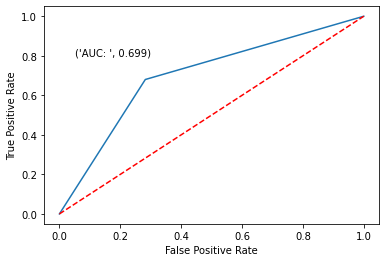

In [99]:
plt.plot(fpr,tpr)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot([0,1],[0,1],'r--')

plt.text(x=0.05,y=0.8,s=('AUC: ',AUC))

plt.show()

The model performance has decreased substantially.

In [100]:
#Tabulating the results

In [101]:
SVM_sigmoid_metrics=pd.Series({'Model':'SVM_Sigmoid',
                            'Accuracy':accuracy_score(y_test,predicted_result),
                             'Recall':recall_score(y_test,predicted_result),
                             'Precision':precision_score(y_test,predicted_result),
                              'AUC_Score':AUC,
                              'f1_score':f1_score(y_test,predicted_result)
                             })
result=result.append(SVM_sigmoid_metrics,ignore_index=True)

result

,Model,Accuracy,Recall,Precision,AUC_Score,f1_score
0,SVM_Linear,0.829,0.75,0.339367,0.794,0.46729
1,SVM_rbf,0.853,0.78,0.384236,0.821,0.514851
2,SVM_Sigmoid,0.714,0.68,0.21118,0.699,0.322275


#### D.Kernel=Poly

In [102]:
svc4=SVC(kernel='poly')

In [103]:
svc4.fit(X_train_scaled,y_train)

SVC(kernel='poly')

In [104]:
predicted_result=svc4.predict(X_test_scaled)

In [105]:
cm4=confusion_matrix(y_test,predicted_result)
cm4

array([[770, 130],
       [ 21,  79]], dtype=int64)

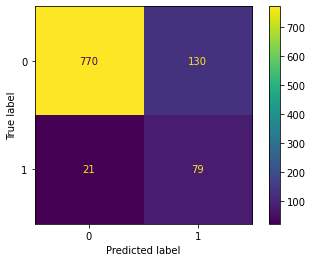

In [106]:
ConfusionMatrixDisplay(cm4).plot()
plt.show()

In [107]:
print(classification_report(y_test,predicted_result))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       900
           1       0.38      0.79      0.51       100

    accuracy                           0.85      1000
   macro avg       0.68      0.82      0.71      1000
weighted avg       0.91      0.85      0.87      1000



In [108]:
fpr,tpr,thresholds=roc_curve(y_test,predicted_result)

In [109]:
AUC=auc(fpr,tpr).round(3)

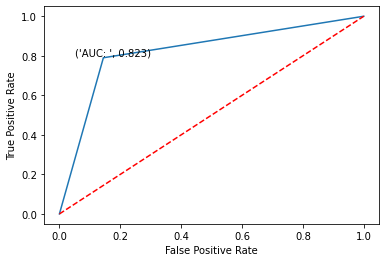

In [110]:
plt.plot(fpr,tpr)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot([0,1],[0,1],'r--')

plt.text(x=0.05,y=0.8,s=('AUC: ',AUC))

plt.show()

This is comparatively good model as compared to others with accuracy of 85%,recall of 82% and AUC score of 0.837

In [111]:
#Tabulating the Results

In [112]:
SVM_poly_metrics=pd.Series({'Model':'SVM_Poly',
                            'Accuracy':accuracy_score(y_test,predicted_result),
                             'Recall':recall_score(y_test,predicted_result),
                             'Precision':precision_score(y_test,predicted_result),
                              'AUC_Score':AUC,
                              'f1_score':f1_score(y_test,predicted_result)
                             })
result=result.append(SVM_poly_metrics,ignore_index=True)

result

,Model,Accuracy,Recall,Precision,AUC_Score,f1_score
0,SVM_Linear,0.829,0.75,0.339367,0.794,0.46729
1,SVM_rbf,0.853,0.78,0.384236,0.821,0.514851
2,SVM_Sigmoid,0.714,0.68,0.21118,0.699,0.322275
3,SVM_Poly,0.849,0.79,0.37799,0.823,0.511327


#### E.Kernel=Poly with GridSearchCV

In [113]:
tuned_parameters={'degree':[2,4,6],'gamma':['auto','scale'],'C':[0.25,0.5,1]}

In [114]:
gs_model=GridSearchCV(estimator=SVC(kernel='poly'),param_grid=tuned_parameters,scoring='accuracy',cv=5)
gs_model.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'C': [0.25, 0.5, 1], 'degree': [2, 4, 6],
                         'gamma': ['auto', 'scale']},
             scoring='accuracy')

In [115]:
print('Best Parameters are: ',gs_model.best_params_)

Best Parameters are:  {'C': 1, 'degree': 4, 'gamma': 'auto'}


In [116]:
#rebuilding the model with tuned parameters

In [128]:
svc5=SVC(kernel='poly',degree=4,gamma='auto',C=1)

In [129]:
svc5.fit(X_train_scaled,y_train)

SVC(C=1, degree=4, gamma='auto', kernel='poly')

In [130]:
predicted_result=svc5.predict(X_test_scaled)

In [131]:
cm5=confusion_matrix(y_test,predicted_result)
cm5

array([[761, 139],
       [ 29,  71]], dtype=int64)

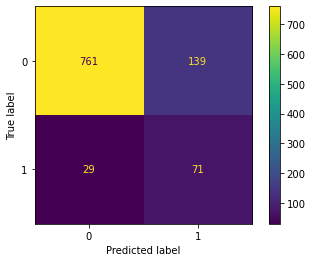

In [132]:
ConfusionMatrixDisplay(cm5).plot()
plt.show()

In [133]:
print(classification_report(y_test,predicted_result))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       900
           1       0.34      0.71      0.46       100

    accuracy                           0.83      1000
   macro avg       0.65      0.78      0.68      1000
weighted avg       0.90      0.83      0.86      1000



In [134]:
fpr,tpr,thresholds=roc_curve(y_test,predicted_result)

In [135]:
AUC=auc(fpr,tpr).round(3)

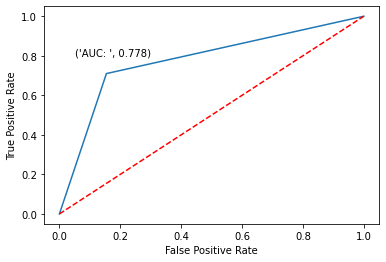

In [136]:
plt.plot(fpr,tpr)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot([0,1],[0,1],'r--')

plt.text(x=0.05,y=0.8,s=('AUC: ',AUC))

plt.show()

After finetuning parameters using GridSearchCV, we can find that the AUC has slightly decreased to 0.792.

In [137]:
#Tabulating the Result

In [138]:
SVM_poly_wihGridSearchCV_metrics=pd.Series({'Model':'SVM_Poly_with_GridSearchCV',
                            'Accuracy':accuracy_score(y_test,predicted_result),
                             'Recall':recall_score(y_test,predicted_result),
                             'Precision':precision_score(y_test,predicted_result),
                              'AUC_Score':AUC,
                              'f1_score':f1_score(y_test,predicted_result)
                             })
result=result.append(SVM_poly_wihGridSearchCV_metrics,ignore_index=True)

result

,Model,Accuracy,Recall,Precision,AUC_Score,f1_score
0,SVM_Linear,0.829,0.75,0.339367,0.794,0.46729
1,SVM_rbf,0.853,0.78,0.384236,0.821,0.514851
2,SVM_Sigmoid,0.714,0.68,0.21118,0.699,0.322275
3,SVM_Poly,0.849,0.79,0.37799,0.823,0.511327
4,SVM_Poly_with_GridSearchCV,0.832,0.71,0.338095,0.778,0.458065
5,SVM_Poly_with_GridSearchCV,0.832,0.71,0.338095,0.778,0.458065


We can see that Poly Kernel has the best results in terms of accuracy and other parameters. So we can consider this as the best model for this data.